In [2]:
import sklearn.datasets
import sklearn.metrics
import sklearn.model_selection

# From OpenML: https://www.openml.org/search?type=data&status=active&id=43672
dataset_name = "Heart-Disease-Dataset-(Comprehensive)"


def get_data_and_scoring_function(dataset_name):
    X, y = sklearn.datasets.fetch_openml(dataset_name, as_frame=True, return_X_y=True)
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
        X,
        y,
        random_state=0,
        stratify=y,
    )

    def scoring_function(estimator):
        predictions = estimator.predict_proba(X_test)[:, 1]
        return sklearn.metrics.roc_auc_score(y_test, predictions)

    def train_scoring_function(estimator):
        predictions = estimator.predict_proba(X_train)[:, 1]
        return sklearn.metrics.roc_auc_score(y_train, predictions)

    def get_test_data():
        return X_test, y_test

    return (
        X,
        y,
        X_train,
        y_train,
        get_test_data,
        scoring_function,
        train_scoring_function,
    )


X, y, X_train, y_train, get_test_data, scoring_function, train_scoring_function = (
    get_data_and_scoring_function(dataset_name)
)

X_test, y_test = get_test_data()

print(f"Done Processing and downloading {dataset_name}")

/home/skhani/anaconda3/envs/SMAC2/lib/python3.10/site-packages/sklearn/datasets/_openml.py:322: UserWarning: Multiple active versions of the dataset matching the name heart-disease-dataset-(comprehensive) exist. Versions may be fundamentally different, returning version 1. Available versions:
- version 1, status: active
  url: https://www.openml.org/search?type=data&id=43672
- version 2, status: active
  url: https://www.openml.org/search?type=data&id=43682

  warn(warning_msg)


Done Processing and downloading Heart-Disease-Dataset-(Comprehensive)


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# continuous and categorical features
continuous_features = [
    "age",
    "resting_bp_s",
    "cholesterol",
    "max_heart_rate",
    "oldpeak",
]
categorical_features = [
    "sex",
    "chest_pain_type",
    "fasting_blood_sugar",
    "resting_ecg",
    "exercise_angina",
    "ST_slope",
]

# Preprocessing for continuous features: Standardization
# Preprocessing for categorical features: One-Hot Encoding
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), continuous_features),
        ("cat", OneHotEncoder(), categorical_features),
    ]
)

pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", RandomForestClassifier(random_state=42)),
    ]
)

# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

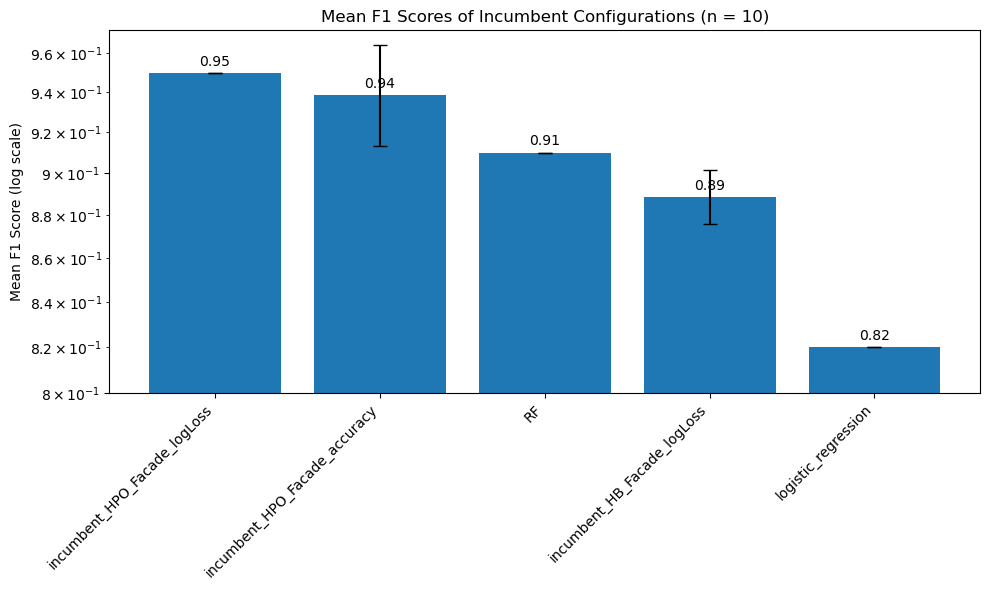

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import json


def test_score_rf(incumbent, seed=42):
    """Evaluates model performance."""
    clf = RandomForestClassifier(**incumbent, random_state=seed)
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    return (
        accuracy_score(y_test, predictions),
        classification_report(y_test, predictions, output_dict=True)["weighted avg"][
            "f1-score"
        ],
    )


file_paths = [
    "incumbent_HPO_Facade_accuracy.json",
    "incumbent_HPO_Facade_logLoss.json",
    "incumbent_HB_Facade_logLoss.json",
]
results = {}

for file_path in file_paths:
    with open(file_path, "r") as file:
        incumbents = json.load(file)

    scores = [test_score_rf(inc, seed=42)[1] for inc in incumbents.values()]
    results[file_path.replace(".json", "").split("/")[-1]] = (
        np.mean(scores),
        np.std(scores),
    )

# Manually adding logistic_regression and RF with their scores and setting SD to 0
results["logistic_regression"] = (0.82, 0)  # (Mean F1 Score, SD)
results["RF"] = (0.91, 0)  # (Mean F1 Score, SD)

# Sort results based on mean value in descending order
sorted_results = dict(
    sorted(results.items(), key=lambda item: item[1][0], reverse=True)
)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(
    sorted_results.keys(),
    [mean for mean, _ in sorted_results.values()],
    yerr=[sd for _, sd in sorted_results.values()],
    capsize=5,
)

ax.set_ylabel("Mean F1 Score (log scale)")
ax.set_title("Mean F1 Scores of Incumbent Configurations (n = 10)")
ax.set_yscale("log")
# Adjusting the alignment of x-axis tick labels
plt.xticks(rotation=45, ha="right")
plt.yticks(np.arange(0.8, 1, 0.1))

# Adding text on top of each bar for the number of runs
for bar in bars:
    height = bar.get_height()
    ax.annotate(
        "%.2f" % height,
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 3),  # 3 points vertical offset
        textcoords="offset points",
        ha="center",
        va="bottom",
    )

plt.tight_layout()
plt.show()